# Stroke Prediction Analysis with ML

Hi! Welcome to the notebook!

This notebook will serve as the step by step code explanation on how I analyse the stroke prediction dataset. The decision made based on the result will be summarized using powerpoint presentation. Please do let me know if you have any suggestions for the methods I'm using in this notebook!

# Dataset Exploration
As part of our journey in using this dataset, it's best for us to understand the properties of what we are working on. Let's start with the very first step, data cleaning.

### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

from imblearn.over_sampling import SMOTE 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.metrics import accuracy_score, recall_score, precision_score


### Load dataset

In [2]:
#read the datasets
stroke = pd.read_csv('stroke.csv')

In [3]:
#print top 5 datasets values
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
#type, and non null datasets
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Check for duplication and NA value on dataset

In [5]:
#check duplicated values
stroke.duplicated().sum()

0

In [6]:
#check NA or NAN values
stroke.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The stroke data set has 201 null data, then we check if it is still below the threshold limit of <5%

In [7]:
# percentage version
stroke.isna().sum() * 100 / len(stroke)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

Because the dataset is still have NA values below the threshold so we can drop the column `bmi` that containing NA values

In [8]:
# drop na values
stroke = stroke.dropna()

In [9]:
# recheck data stroke
stroke.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Now dataset is clean and ready to use

# EDA Section

### Statistical summary of column

In [10]:
#split datasets into 2 values
categoricals = ['gender', 'ever_married', 'work_type', 'smoking_status', 'Residence_type']

numericals = ['id', 'age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi', 'stroke' ]

In [11]:
# numerical statistical sumary
stroke[numericals].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,20995.098457,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,77.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,18605.000000,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,37608.000000,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,55220.000000,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Observation:
* Overall, the minimum and maximum values still make sense for all columns except for `bmi`, max bmi is 97.6 but for normal person is considered between 18,5-25
* `hypertension` and `heart_disease` is a boolean/binary column because the value is 0 or 1, there is no need to deduce the symmetry. Because this can be a target variable for modeling.

In [12]:
# describe method on categorical data
stroke[categoricals].describe()

,gender,ever_married,work_type,smoking_status,Residence_type
count,4909,4909,4909,4909,4909
unique,3,2,5,4,2
top,Female,Yes,Private,never smoked,Urban
freq,2897,3204,2811,1852,2490


Observation:
* The `gender` column is dominated by female as many as 2897 people
* column `ever_married`is dominated by yes, so most of participant are married
* The `work_type`column is dominated by private as many as 2811 people
* The `smoking_status` column is dominated by non-smoker as many as 1852 people

## Univariate Analysis

### Boxplot to detect outliers

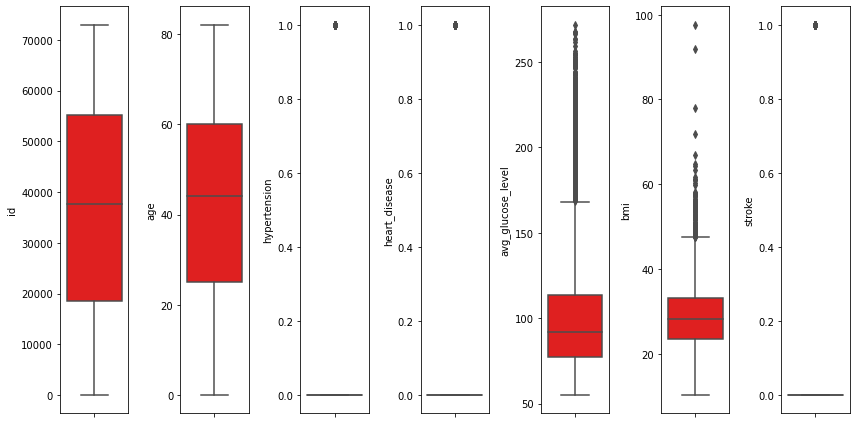

In [13]:
# adjust the figure size for better readability
plt.figure(figsize=(12,6))

# plotting
features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=stroke[features[i]], color='red')
    plt.tight_layout()

Obervation:
1. There is none of outlier in the `age` and `stroke` column 
2. We can skip `hypertension` and `heart_disease` because its contains boolean value
3. There is lot of outlier in colum `avg_glucose_level` and `bmi` its likely most of participant are have high glucose and overweight

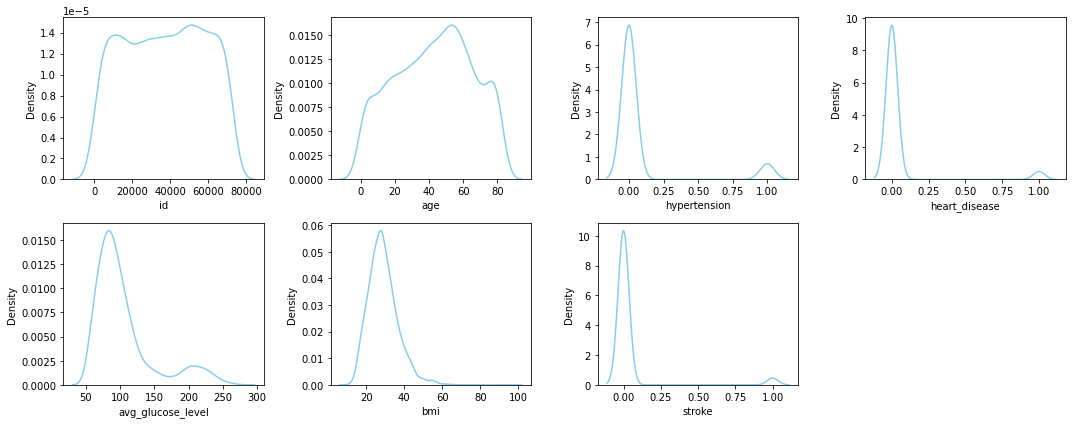

In [14]:
# adjust the figure size for better readability
plt.figure(figsize=(15,6))

features = numericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.kdeplot(x=stroke[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.tight_layout()

Observation:
1. `stroke`, `heart_disease` and `hypertension` column is Boolean, just ignore it
2. Column `age`, `bmi` and `avg_glucose_level` not distributed nicely as either normal or symmetric distribution

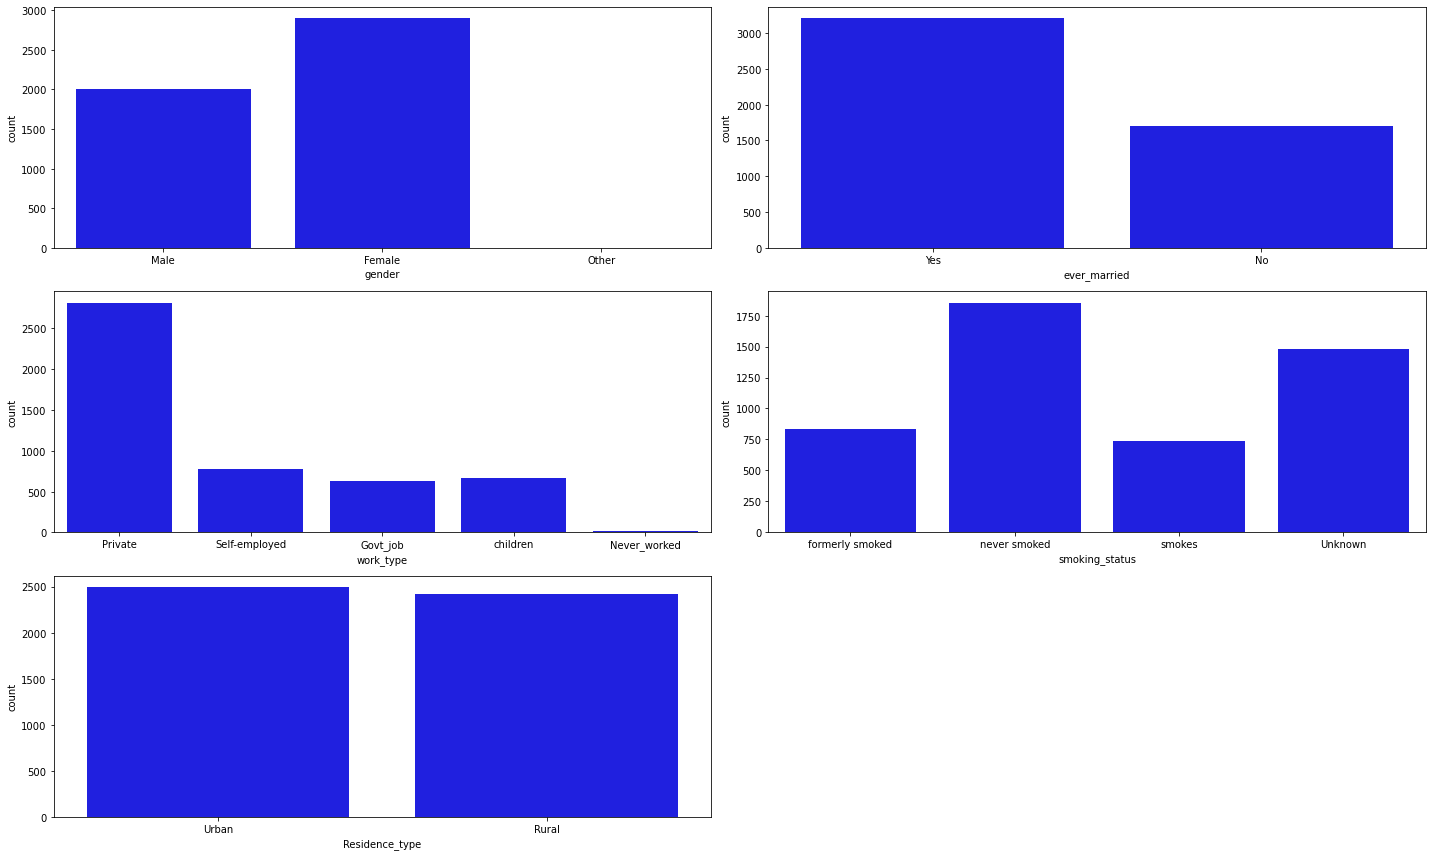

In [15]:
# adjust the figure size for better readability
plt.figure(figsize=(20,12))

features = categoricals
for i in np.arange(1, len(features)+1):
    plt.subplot(3, len(features)//3+1, i)
    sns.countplot(x=stroke[features[i-1]], color='blue')
    plt.xlabel(features[i-1])
    plt.tight_layout()

Observation:
1. visual representations of value counts before

## Multivariate Analysis

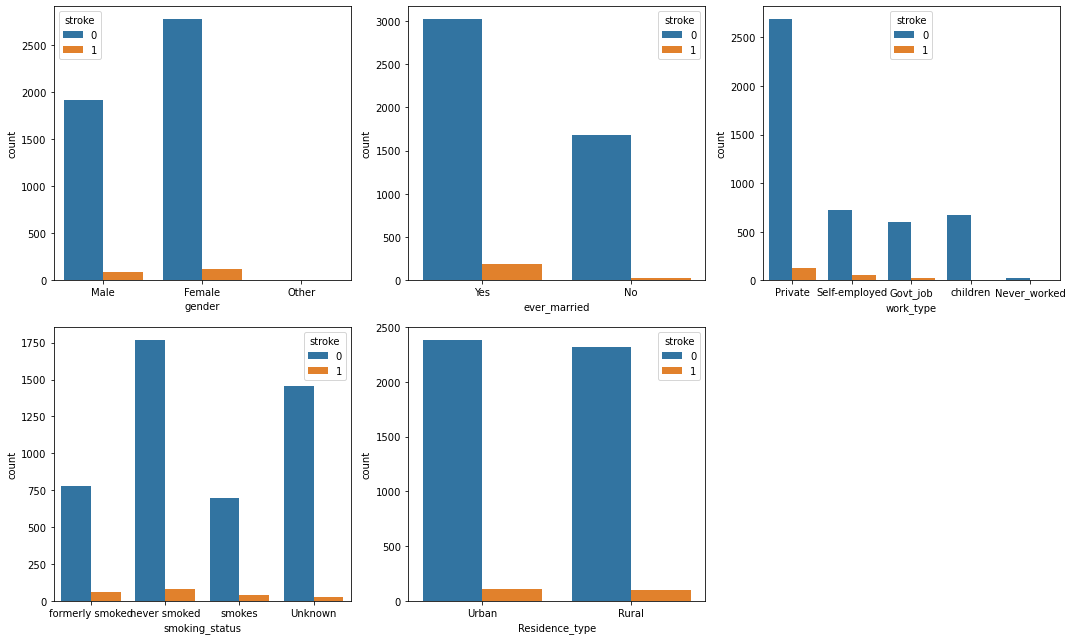

In [16]:
# set target variable (subscribed) as hue
# to understand the different behaviors of each of the features based on subscribe value

# categorical features
# excluding high cardinal features for readability
selected_categoricals = ['gender', 'ever_married', 'work_type', 'smoking_status', 'Residence_type']

plt.figure(figsize=(15,9))

features = selected_categoricals
for i in np.arange(1, len(features)+1):
    plt.subplot(2, len(features)//2+1, i)
    sns.countplot(x=stroke[features[i-1]], hue=stroke['stroke'])
    plt.xlabel(features[i-1])
    plt.tight_layout()

Observation
1. female and male customers have similiar stroke-rate
2. married couple has more stroke-rate
3. private job has biggest stroke-rate
4. people who never smoked has biggest stroke-rate among the person who smokes and formerly smoke

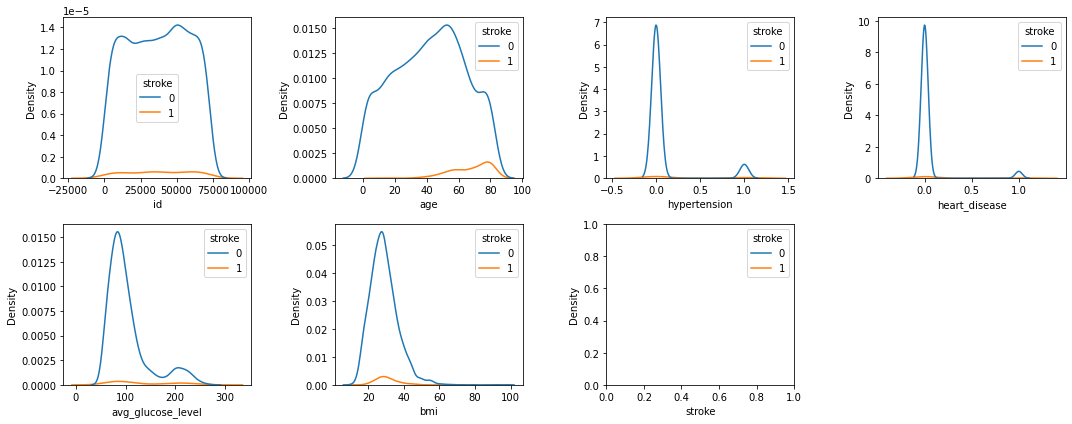

In [17]:
# do the same for numerical features

plt.figure(figsize=(15,6))

features = numericals
for i in np.arange(1, len(features)+1):
    plt.subplot(2, len(features)//2+1, i)
    sns.kdeplot(x=stroke[features[i-1]], hue=stroke['stroke'])
    plt.xlabel(features[i-1])
    plt.tight_layout()

Observation
1. visual representations of value counts before

In [18]:
# next is heatmap correlation
# first it's useful to transform binary categorical columns as numericals
for col in categoricals:
  print(f"{col} distinct values = {stroke[col].nunique()}")

gender distinct values = 3
ever_married distinct values = 2
work_type distinct values = 5
smoking_status distinct values = 4
Residence_type distinct values = 2


In [19]:
# encode binary categorical columns
binary_cols = ['ever_married']

value_mapping = {
    'No': 0,
    'Yes' : 1
}

for col in binary_cols:
    stroke[col] = stroke[col].map(value_mapping)  

stroke[categoricals].head()

,gender,ever_married,work_type,smoking_status,Residence_type
0,Male,1,Private,formerly smoked,Urban
2,Male,1,Private,never smoked,Rural
3,Female,1,Private,smokes,Urban
4,Female,1,Self-employed,never smoked,Rural
5,Male,1,Private,formerly smoked,Urban


<AxesSubplot:>

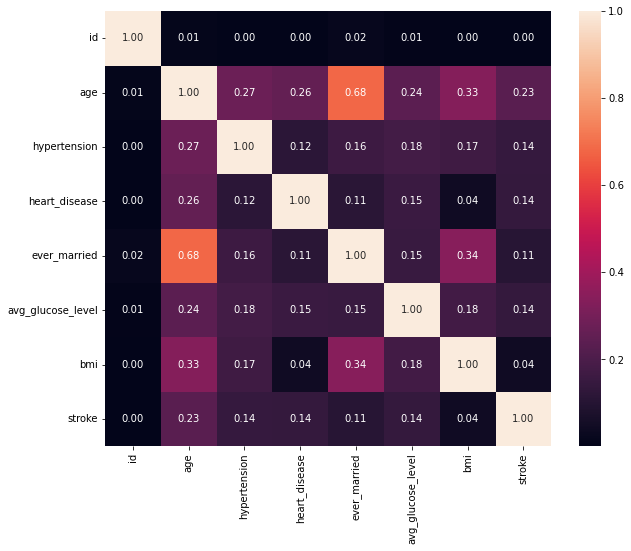

In [20]:
# heatmap correlation
plt.figure(figsize=(10,8))
correlation = stroke.corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

Observation:
1. `ever_married` is decently correlated with `age` 
2. most of colum has small multicorelation

# Modeling Section

### Numerical

In [21]:
data = stroke[['age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi', 'stroke']]

### Feature + Target

In [22]:
X = data.drop('stroke', axis=1)
y = data['stroke']

In [23]:
from sklearn.model_selection import train_test_split 
X_train, X_test,y_train,y_test = train_test_split(X,
                                                y,
                                                test_size = 0.3,
                                                random_state = 42)

In [24]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,age,1.293481
2,hypertension,1.114614
3,heart_disease,1.087563
4,avg_glucose_level,1.105261
5,bmi,1.154772


# Determining Model

In [25]:
#Linear Regresion
from sklearn.linear_model import LinearRegression

# define the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

linreg.score(X_test,y_test)

0.08449441575098793

In [26]:
#Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)

#Check score
dtc.score(X_test,y_test)

0.9164969450101833

In [27]:
#Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

#Check Score
rf.score(X_test,y_test)

0.9504412763068567

In [28]:
#XGboost model

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)

#Check score
xgb_classifier.score(X_test,y_test)

0.9436524100475221

Overall RandomForest has higehst R2 score and Linear Regresion has the lowest

## 1. Linear regresion as base model

In [29]:
from sklearn.linear_model import LinearRegression

# define the model
simple_reg = LinearRegression()

simple_reg.fit(X_train, y_train)

LinearRegression()

In [30]:
# retrieve the coefficients
# show as a nice dataframe

data = X_train
model = simple_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,-0.036660
1,age,0.001600
2,hypertension,0.045444
3,heart_disease,0.058817
4,avg_glucose_level,0.000352
5,bmi,-0.001234


### Model Evaluation

In [31]:
# prepare prediction result on train data
y_predict_stroke = simple_reg.predict(X_train)

### Training Error

In [32]:
# prepare prediction result on training data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# calculate residuals


print('R-squared for training data is {}'.format(r2_score(y_train, y_predict_stroke)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, y_predict_stroke))))

R-squared for training data is 0.06673488721672227
RMSE for training data is 0.18901697211986299


### Testing Error

In [33]:
# prepare prediction result on test data
y_predict_test = simple_reg.predict(X_test)

In [34]:
from sklearn.metrics import mean_squared_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test, y_predict_test))))

RMSE for testing data is 0.2063065743723475


Linear regresion have very low in accuracy score, we will not use this algorithm

# Imbalanced Data handling

In [35]:
target = stroke['stroke'].value_counts().reset_index()
target.rename(columns={'index':'stroke','stroke':'freq'}, inplace=True)
target['percentage'] = round((target['freq']/target['freq'].sum())*100,2)
target

,stroke,freq,percentage
0,0,4700,95.74
1,1,209,4.26


because the data is very unbalanced then we don't do data balancing

In [36]:
datanew = stroke[['gender', 'ever_married', 'work_type', 'smoking_status', 'Residence_type', 'age', 'hypertension', 'heart_disease',
              'avg_glucose_level', 'bmi', 'stroke']]



## Feature Importance with Random Forest Classifier

In [37]:
from sklearn.model_selection import GridSearchCV
params ={'criterion':['gini','entropy'],'max_depth':[4,6,8],'max_features':['auto','log2']}
rf_gridcv = GridSearchCV(rf,params,cv=3)

In [38]:
#Fitting train data
rf_gridcv.fit(X_train,y_train) 

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': ['auto', 'log2']})

In [39]:
#Define best scores
rf_gridcv.best_score_

0.9607101214019526

In [40]:
#Determine the best parameter
print(rf_gridcv.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto'}


In [41]:
#Predict the data
y_pred_test = rf_gridcv.predict(X_test)

# Metrics Result

In [42]:
#Import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1401
           1       0.00      0.00      0.00        72

    accuracy                           0.95      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.90      0.95      0.93      1473



## Is the model overfit or underfit?

In [44]:
y_pred_train = rf_gridcv.predict(X_train)
y_pred_test = rf_gridcv.predict(X_test)
y_proba_train = rf_gridcv.predict_proba(X_train)[:,1]
y_proba_test = rf_gridcv.predict_proba(X_test)[:,1]

In [45]:
#Accuracy score of training data
print(accuracy_score(y_train, y_pred_train))

0.9627473806752037


In [46]:
#Accuracy score of testing data
print(accuracy_score(y_test, y_pred_test))

0.9511201629327902


training has slightly better that testing data

# Evaluating Model Performance

In [47]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, log_loss

In [48]:
y_pred_train = rf_gridcv.predict(X_train)
y_pred_test = rf_gridcv.predict(X_test)
y_proba_train = rf_gridcv.predict_proba(X_train)[:,1]
y_proba_test = rf_gridcv.predict_proba(X_test)[:,1]
cm_train = confusion_matrix(y_train,y_pred_train)
cm_test = confusion_matrix(y_test,y_pred_test)

In [49]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

In [50]:
# True Positive
tp_train, tp_test = cm_train[1][1], cm_test[1][1]
# True Negative
tn_train, tn_test = cm_train[0][0], cm_test[0][0]
# False Positive
fp_train, fp_test = cm_train[1][0], cm_test[1][0]
# False Negative
fn_train, fn_test = cm_train[0][1], cm_test[0][1]

In [51]:
# Overall, how often is the classifier correct?
accuracy_train, accuracy_test = ((tp_train + tn_train) / (tp_train + tn_train + fp_train + fn_train)), (
            (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test))
# When it's actually yes, how often does it predict yes?
recall_train, recall_test = (tp_train / (tp_train + fp_train)), (tp_test / (tp_test + fp_test))
# When it's actually no, how often does it predict no?
specificity_train, specificity_test = (tn_train / (tn_train + fn_train)), (tn_test / (tn_test + fn_test))
# When it predicts yes, how often is it correct?
precision_train, precision_test = (tp_train / (tp_train + fn_train)), (tp_test / (tp_test + fn_test))
# F1 Score
f1_score_train, f1_score_test = (2 * (precision_train * recall_train) / (precision_train + recall_train)), (
            2 * (precision_test * recall_test) / (precision_test + recall_test))


Train Confusion Matrix
[[3299    0]
 [ 128    9]]
Test Confusion Matrix
[[1401    0]
 [  72    0]]

Area Under Curve
AUC train & test        : 98.37% & 84.03%

Confusion Matrix Evaluation
Accuracy train & test   : 96.27% & 95.11%
Recall train & test     : 6.57% & 0.00%
Log Loss train & test   : 1.2867 & 1.6882


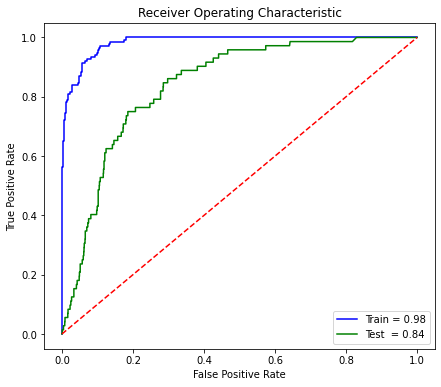

In [54]:
# Print all the evaluation metrics
print('\nTrain Confusion Matrix')
print(cm_train)
print('Test Confusion Matrix')
print(cm_test)
print('\nArea Under Curve')
print('AUC train & test        : %.2f%%' % (roc_auc_train * 100), '&', '%.2f%%' % (roc_auc_test * 100))
print('\nConfusion Matrix Evaluation')
print('Accuracy train & test   : %.2f%%' % (accuracy_train * 100), '&', '%.2f%%' % (accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (recall_train * 100), '&', '%.2f%%' % (recall_test * 100))
print('Log Loss train & test   :', round(log_loss(y_train, y_pred_train), 4), '&',
          round(log_loss(y_test, y_pred_test), 4))

#create plot of ROC_AUC
plt.figure(figsize=(7, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label='Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'g', label='Test  = %0.2f' % roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Because it is no longer balanced data, so it is NOT valid to use accuracy
use AUC or F1 score